<a href="https://colab.research.google.com/github/Mkenza/Computer_V_SDI/blob/master/TP2_MAKHLOUF_FaceDestection_and_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction au traitement d’image avec Python / OpenCV - partie 3**

**Détection de visage dans une image**

Vous pouvez détecter les visages dans une image en utilisant le détecteur de visage d’opencv qui est implémenté avec un classifier CascadeClassifier. Fondamentalement, il effectue une opération simple. Étant donné une image, le détecteur de visage examiner chaque emplacement de l'image et il classifie comme "visage" ou "non visage". Opencv contient déjà de nombreux classifieurs pré-entrainés pour le visage, les yeux, le sourire, etc. Ces fichiers XML sont stockés dans le dossier ressources/haarcascades/. 
Nous utilisons  v2.CascadeClassifier.detectMultiScale() pour détecter le visage, les yeux, etc. et cette fonction est définie comme :

cv2.CascadeClassifier.detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]) 

Ses paramètres sont:
image: matrice de type CV_8U contenant une image où des objets sont détectés.
scaleFactor: paramètre spécifiant la réduction de la taille de l'image à chaque échelle d'image. Ce facteur d'échelle est utilisé pour créer une pyramide d'échelle comme indiqué dans l'image. minNeighbors: paramètre spécifiant le nombre de voisins que chaque rectangle candidat doit avoir pour le conserver. Ce paramètre affectera la qualité des visages détectés: une valeur plus élevée entraîne moins de détections mais avec une qualité supérieure. Nous utilisons 5 dans le code. Si des faces sont trouvées, elle renvoie les positions des faces détectées en Rect (x, y, w, h).
Il suffit maintenant de parcourir les zones de visage dans faces et dessiner les cadres autour des visages trouvés. Voici le code :


In [1]:
# monter votre Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Télécharger la base ici:
https://drive.google.com/file/d/137nl0lyjHRwecMP_Ncbf6wpQT5RNg0QW/view?usp=sharing

In [3]:
# récupérer les données en fichier zip et l'extraire ici

from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Data-Face.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


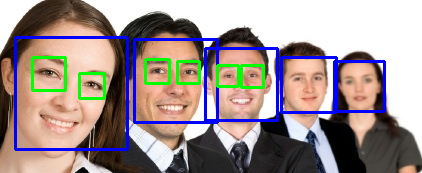

In [4]:
import numpy as np
import cv2
import imutils
import numpy as np
from google.colab.patches import cv2_imshow

from matplotlib import pyplot as plt

# initialize the Haar Cascade face detection model 
face_cascade = cv2.CascadeClassifier('Data-Face/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('Data-Face/haarcascades/haarcascade_eye.xml')

# directement aussi
#face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))
#eye_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_eye.xml'))


img = cv2.imread('Data-Face/Group-Faces.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)


for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

cv2_imshow(img)


***Exercice 1*** : écrire un programme qui permet, à l’aide du détecteur réaliser dans ce TP, de détecter le visage à partir d’une séquence d’images capturées par une webcam avec des poses différentes. L’objectif ici est de créer une base de visage de maximum de personnes (promotion JUNIA) avec une vingtaine d’image par personne (différentes poses, différentes échelles, différentes expressions, etc.). Les visages détectés doivent être redimensionnés tous à une seule taille (250x250). 

In [5]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "Status:";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '' +
          'When finished, click here or on the video to stop this demo';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [7]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      roi_gray = gray[y:y+h, x:x+w]
      roi_color = bbox_array[y:y+h, x:x+w]
      eyes = eye_cascade.detectMultiScale(roi_gray)
      for (ex,ey,ew,eh) in eyes:
          cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

**Reconnaissance de visage dans une image** 

L’objectif de ce TP est de développer un système, basé sur la méthode de reconnaissance faciale par un des algorithmes Eigenfaces, FisherFace ou LPBFace implémentés dans opencv, capables de reconnaître un visage à partir d’une base de données de visages de référence et d’étudier les propriétés de cette méthode et ses limitations.

La méthode de reconnaissance doit être développée et appliquée, en premier temps, sur une base d’image de visage et ensuite combinée avec le détecteur de visage. La première étape dans un système de reconnaissance faciale est de créer le modèle d’apprentissage à partir d’une base de visages et leurs identités.
Afin de réaliser la phase d’apprentissage, utiliser l’interface développée dans l’exercice précédent afin de réaliser l’acquisition d’une base d’apprentissage de visages. 

In [8]:
# récupérer les données en fichier zip et l'extraire ici

from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Data-FaceDetection and Recognition.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


####2015 Database

In [66]:
faces[0].shape

(150, 150)

In [128]:
import pandas as pd
import os
df = pd.read_csv("Data-FaceDetection and Recognition/FaceRecog-BD-2015/Dection_faces/listname", sep=";", names=["files", "class"])
face_path = "Data-FaceDetection and Recognition/FaceRecog-BD-2015/Dection_faces"
faces = [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(face_path, file)), cv2.COLOR_RGB2GRAY), (200, 200)) for file in os.listdir(face_path) if "jpg" in file]

In [129]:
labels = []
for file in os.listdir(face_path):
  if "jpg" in file:
    for i, x in enumerate(df["files"]):
      if x in file:
        labels.append(df["class"][i])

####2016 Database

In [130]:
face_path_2016 = "Data-FaceDetection and Recognition/FaceRecog-BD-2016/Training"
faces += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(face_path_2016, file)), cv2.COLOR_RGB2GRAY), (200, 200)) for file in os.listdir(face_path_2016) if "png" in file]
labels += [int(file[0])+4 for file in os.listdir(face_path_2016) if "png" in file]

In [110]:
len(labels), len(faces)

(165, 165)

####2018 Database

In [131]:
face_path_2018 = "Data-FaceDetection and Recognition/FaceRecog-BD-2018/Train/"
for folder in os.listdir(face_path_2018):
  if folder.isdigit():
    folder_path = os.path.join(face_path_2018, folder)
    faces += [cv2.resize(cv2.cvtColor(cv2.imread(os.path.join(folder_path, file)), cv2.COLOR_RGB2GRAY), (200, 200)) for file in os.listdir(folder_path) if "png" in file]
    labels += [int(folder)+12 for file in os.listdir(folder_path) if "png" in file]

In [81]:
len(labels), len(faces)

(269, 269)

#### Visualize the image data (ids)

In [132]:
ids = [labels[0]]
occurence = [0]
for i, x in enumerate(labels[1:]):
  if x not in ids:
    ids.append(x)
    occurence.append(i+1)

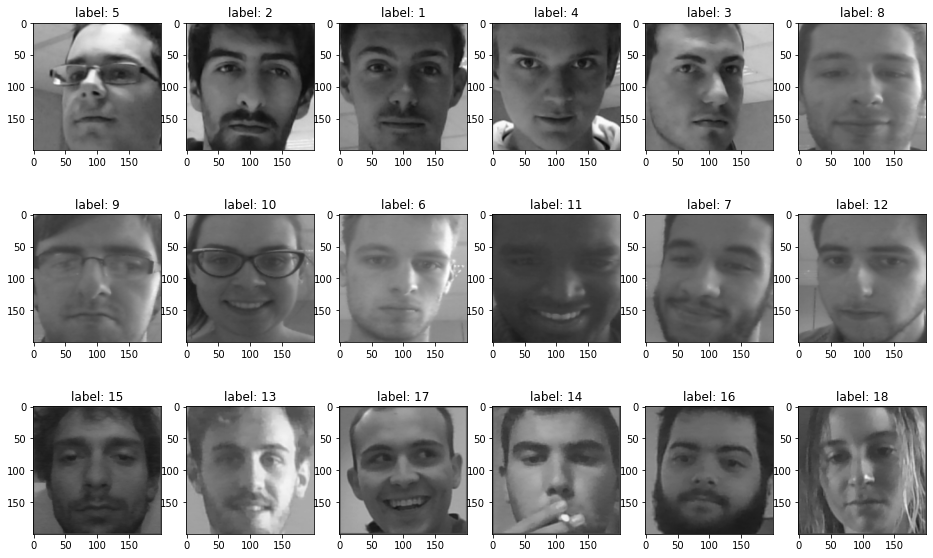

In [133]:
fig, axs = plt.subplots(nrows=3, ncols=6, figsize=(16,10))
ax = axs.flatten()[0]
for i, ax in enumerate(axs.flatten()):
  im = cv2.cvtColor(faces[occurence[i]], cv2.COLOR_GRAY2RGB)
  ax.imshow(im)
  ax.title.set_text(f"label: {ids[i]}")

#### Train the model on 269 training images/labels

True label : 15
Predicted label : 15


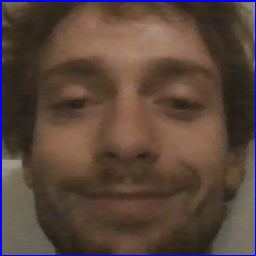

In [135]:
# Initialiser de la reconnaissance de visage (tester different recognizers)
face_recognizer = cv2.face.EigenFaceRecognizer_create()
# face_recognizer = cv2.face.LBPHFaceRecognizer_create()

#Pour entertainer un modèle d’apprentissage sur cette base, il suffit d’appliquer la méthode :
face_recognizer.train(faces, np.array(labels))
img = cv2.imread("/content/Data-FaceDetection and Recognition/FaceRecog-BD-2018/Train/3/facesmi7.png")
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Ensuite, la reconnaissance d’un visage se fait avec la méthode:
label = face_recognizer.predict(cv2.resize(gray, (200, 200)))
print("True label : 15")
print("Predicted label :", label[0])

cv2_imshow(img)

L'algorithme de reconnaissance peut donc bien prédire la personne dans l'image, cette image fait partie des images d'entraînemeent donc on peut pas encore conclure sur la performance du modèle.

***Exercice 2*** : Combiner la méthode de reconnaissance avec le détecteur de visage dans une image. Afin de réaliser cette combinaison, il faut rogner la zone de visage à partir de l’image contenant un visage. Ensuite, utiliser l’image rognée comme l’image de test à reconnaitre. Afficher en texte ensuite le label prédit dans la zone du visage.

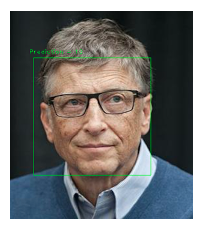

Étendre votre méthode sur la reconnaissance multiple des visages dans l’image :

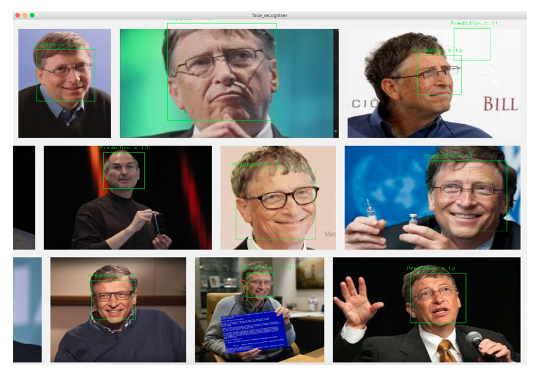

Vous pouvez travaller la partie recon naissance directement sur cette base:
https://drive.google.com/file/d/1OFDDpNpoHH5gE_Pu8EgNLv6ifgio3wJu/view?usp=sharing

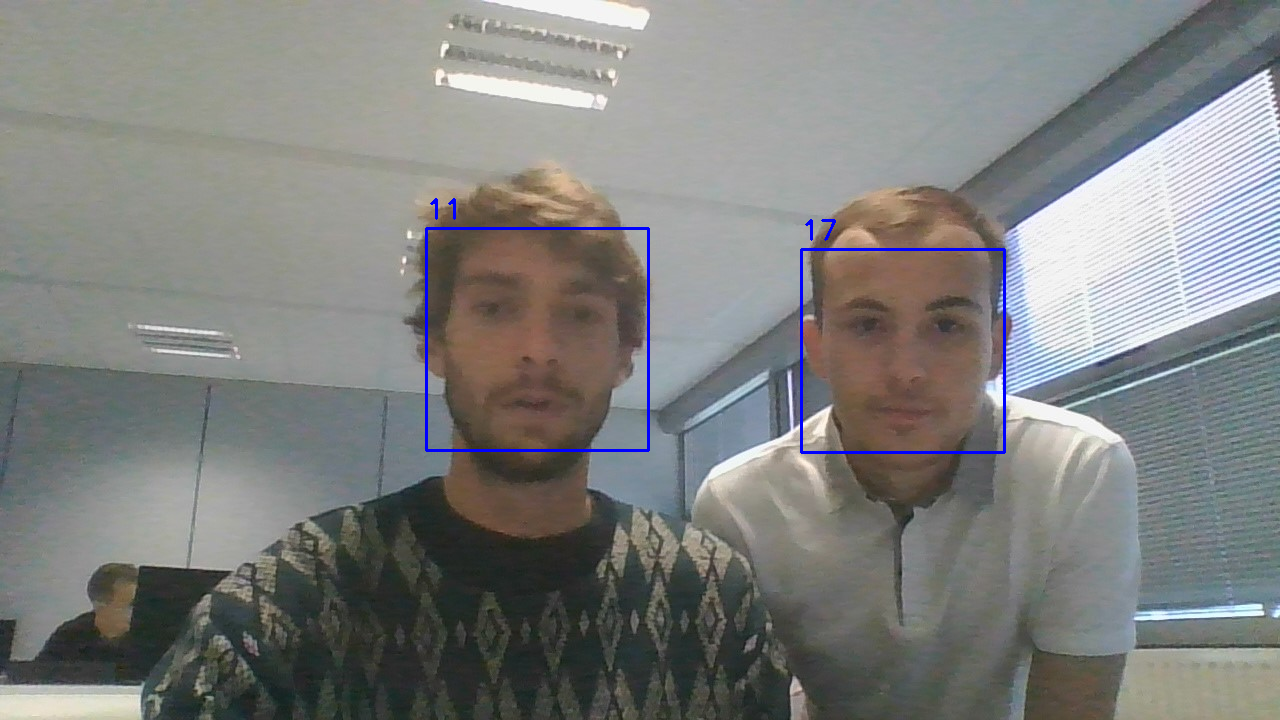

In [142]:
def multi_det_recog(img):
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  for (x,y,w,h) in faces:
      # draw bounding box
      cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
      # get the gray scaled bounding box and resized to the input size of the model 
      roi_gray = gray[y:y+h, x:x+w]
      roi_gray_resize = cv2.resize(roi_gray, (200, 200))
      # get the predicted label
      label = face_recognizer.predict(roi_gray_resize)
      # write the label on the bounding box
      cv2.putText(img, str(label[0]), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)
  cv2_imshow(img)

image = cv2.imread("/content/Data-FaceDetection and Recognition/FaceRecog-BD-2018/Test/test2.jpg")
multi_det_recog(image)

En itérant sur les visages détéctés par l'algorithme de détection, puis passer chaque visage à l'algorithme de reconnaissance, on peut créer un pprogramme de détection et de reconnaissance pour une image. Puis l'étendre au vidéos (séquence d'images).

In [139]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
        cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray_resize = cv2.resize(roi_gray, (200, 200))
        label = face_recognizer.predict(roi_gray_resize)
        cv2.putText(bbox_array, str(label[0]), (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,0,0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>